### Exploraty Problem (2) : Are there particular locations in Seattle where AirBnb listings fetch higher prices?

In [3]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set()
import os
import sys

os.environ["PYSPARK_PYTHON"] = "python3.10"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3.10"
print(sys.version)


3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


In [4]:
spark = SparkSession.builder \
    .master("local[3]") \
    .appName("Airbnb Listings") \
    .getOrCreate()  

#### 1.Load the parquet dataset


In [5]:
listings_df = spark.read \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .parquet("cleaned_listings.parquet")

listings_df.show(5)

+-------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+----------------+---------------------+----------------------+--------+---------+----------+------------------+--------------------+-------+--------------------+-------------+---------------+------------+---------+--------+----+-----------------+--------------------+-------------------+-----------------+-----+
|     id|                name|             summary|          longitude|          latitude|               space|         description|instant_bookable|neighborhood_overview|neighbourhood_cleansed| host_id|host_name|host_since|host_response_time|              street|zipcode|review_scores_rating|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|reviews_per_month|           amenities|cancellation_policy|number_of_reviews|price|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+-

#### 2.Plotting a heatmap of the neighbourhoods vs property type with the median price


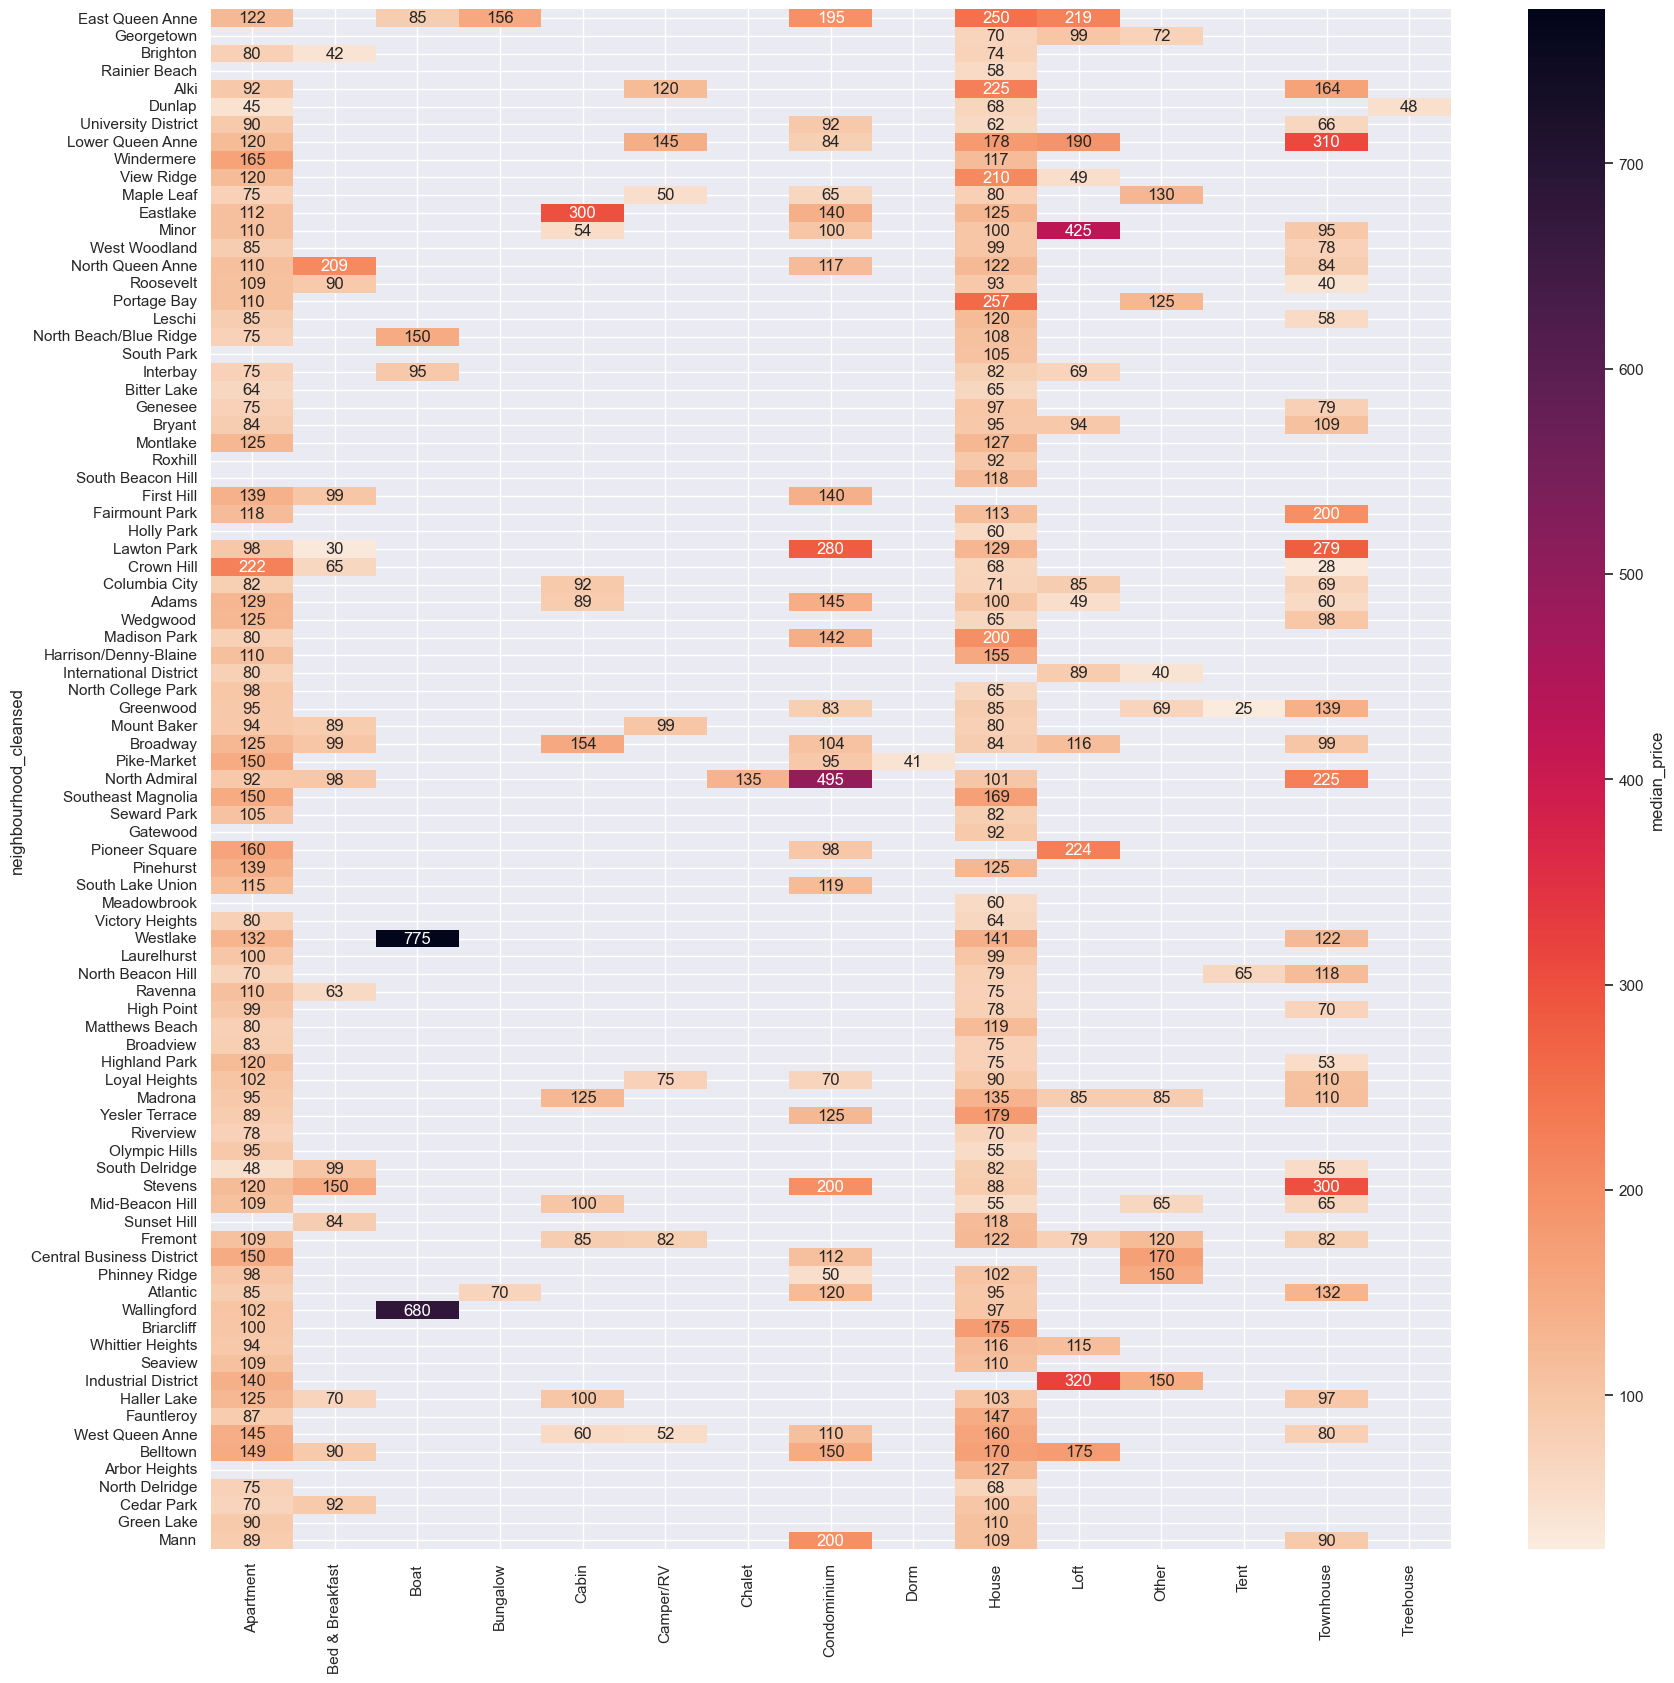

In [6]:
# Group by 'neighbourhood_cleansed' and 'property_type', compute median price
grouped_df = listings_df.groupby('neighbourhood_cleansed', 'property_type') \
                      .agg({"price": "median"}) \
                      .withColumnRenamed("median(price)", "median_price")

# Pivot the DataFrame to create a matrix
pivot_df = grouped_df.groupby('neighbourhood_cleansed') \
                    .pivot('property_type') \
                    .agg({"median_price": "first"})

# Convert the pivoted DataFrame to a Pandas DataFrame
pivot_pandas_df = pivot_df.toPandas()

# Plotting the heatmap using Seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(pivot_pandas_df.set_index('neighbourhood_cleansed'), annot=True, fmt=".0f", cmap="rocket_r", cbar_kws={'label': 'median_price'})
plt.show()


#### ** Conclusion: First is that the majority of listing types (Apartments & Houses) are listed in almost all neighbourhoods. The second thing we can infer is that there are some neighbourhood rows which tend to be darker than other neighbourhood rows in the heatmap above. This could possibly mean location might have some influence in the price. So, we will analyze this further.

In [7]:
print(listings_df)

DataFrame[id: bigint, name: string, summary: string, longitude: double, latitude: double, space: string, description: string, instant_bookable: string, neighborhood_overview: string, neighbourhood_cleansed: string, host_id: bigint, host_name: string, host_since: date, host_response_time: string, street: string, zipcode: int, review_scores_rating: double, property_type: string, room_type: string, accommodates: bigint, bathrooms: double, bedrooms: double, beds: double, reviews_per_month: double, amenities: string, cancellation_policy: string, number_of_reviews: bigint, price: float]


#### Analysing number of listings of each room type in the neighbourhoods
##### We will find out which area in Boston has maximum listings on Airbnb


In [8]:
# Getting the room type corresponding to home/apt , private and shared
home = listings_df.filter(listings_df.room_type == 'Entire home/apt')
private = listings_df.filter(listings_df.room_type == 'Private room')
shared = listings_df.filter(listings_df.room_type == 'Shared room')

# Extract the location of each room type
location_home = home.select('latitude', 'longitude')
location_private = private.select('latitude', 'longitude')
location_shared = shared.select('latitude', 'longitude')

location_home.show()  # To display the DataFrame

+------------------+-------------------+
|          latitude|          longitude|
+------------------+-------------------+
|47.636289038357184|-122.37102519997764|
| 47.63912312136253|-122.36566646439582|
| 47.62972413157736| -122.3694831756176|
| 47.63291840276724|-122.37247063402224|
| 47.63749172022628| -122.3668885909212|
| 47.63548170841016|-122.35847776162176|
| 47.63721407513561| -122.3600457614146|
| 47.63554551151239|-122.37317075183506|
| 47.62950680923431| -122.3676292967417|
| 47.63920265551509|-122.36586274154313|
| 47.63564979343857|-122.37289282480928|
| 47.63602477658138|-122.35869359564737|
| 47.62794033813239|-122.36495872243864|
| 47.63563222417987|-122.35888090262146|
| 47.63851671212965|-122.36958103291498|
| 47.63139734518299|  -122.367766870679|
| 47.62990711611138|-122.36894813824875|
| 47.63981586823574|-122.37433846349175|
| 47.63900777818944|-122.36532007300232|
| 47.63508504491007|-122.36444347330422|
+------------------+-------------------+
only showing top

In [9]:
from bokeh.io import output_notebook
from bokeh.models import GMapOptions, ColumnDataSource, Circle, BoxSelectTool
from bokeh.plotting import gmap, show, save


# Assuming location_home, location_private, and location_shared are Spark DataFrames
# You may need to adjust the lat_home, lon_home, etc. column names according to your Spark DataFrame
source = ColumnDataSource(
    data=dict(
        lat_home=location_home.select("latitude").collect(),
        lon_home=location_home.select("longitude").collect(),
        lat_private=location_private.select("latitude").collect(),
        lon_private=location_private.select("longitude").collect(),
        lat_shared=location_shared.select("latitude").collect(),
        lon_shared=location_shared.select("longitude").collect()
    )
)

map_options = GMapOptions(lat=47.605775, lng=-122.333163, map_type="roadmap", zoom=11)
plot = gmap("", map_options, title="Seattle")

circle_home = Circle(x="lon_home", y="lat_home", size=4, fill_color="yellow", fill_alpha=0.9, line_color=None)
circle_private =  Circle(x="lon_private", y="lat_private", size=4, fill_color="red", fill_alpha=0.9, line_color=None)
circle_shared =  Circle(x="lon_shared", y="lat_shared", size=4, fill_color="blue", fill_alpha=0.9, line_color=None)

plot.add_glyph(source, circle_home)
plot.add_glyph(source, circle_private)
plot.add_glyph(source, circle_shared)

plot.add_tools(BoxSelectTool())

output_notebook()
show(plot)
from bokeh.plotting import figure, output_file, save

# Alternatively, if you want to save the plot as an HTML file
output_file("map.html")
save(plot)


ModuleNotFoundError: No module named 'bokeh'

## Finding the number of listings for each neighbourhood and median price


In [ ]:
# Grouping neighbourhood by number of listings and then cleaning them
neighbourhood_DF = home.groupBy('neighbourhood_cleansed').count()
neighbourhood_DF = neighbourhood_DF.withColumnRenamed('count', 'Number_Of_Listings')
neighbourhood_DF = neighbourhood_DF.orderBy(F.desc('Number_Of_Listings'))

# Collecting data to the driver
neighbourhood_DF.show()

+----------------------+------------------+
|neighbourhood_cleansed|Number_Of_Listings|
+----------------------+------------------+
|              Broadway|               167|
|              Belltown|               143|
|               Fremont|                86|
|           Wallingford|                86|
|  Central Business ...|                72|
|                 Minor|                64|
|            First Hill|                62|
|       East Queen Anne|                58|
|   University District|                49|
|               Stevens|                48|
|      Lower Queen Anne|                47|
|                 Adams|                39|
|         Phinney Ridge|                37|
|      North Queen Anne|                35|
|             Greenwood|                35|
|       West Queen Anne|                34|
|                  Mann|                34|
|         West Woodland|                32|
|     North Beacon Hill|                30|
|            Green Lake|        

In [ ]:
# Grouping neighbourhood by average price of listings and cleaning them
neighbourhoodPrice_DF = home.groupBy('neighbourhood_cleansed').agg(F.expr('percentile_approx(price, 0.5)').alias('Median_Price'))
neighbourhoodPrice_DF = neighbourhoodPrice_DF.orderBy(F.desc('Median_Price'))

# Collecting data to the driver
neighbourhoodPrice_DF.show()

+----------------------+------------+
|neighbourhood_cleansed|Median_Price|
+----------------------+------------+
|           Sunset Hill|       350.0|
|    Southeast Magnolia|       225.0|
|            Holly Park|       215.0|
|           Lawton Park|       200.0|
|         Arbor Heights|       200.0|
|         North Admiral|       195.0|
|      South Lake Union|       183.0|
|            Briarcliff|       175.0|
|              Westlake|       170.0|
|         Rainier Beach|       169.0|
|        Yesler Terrace|       165.0|
|            Fauntleroy|       165.0|
|           Portage Bay|       160.0|
|        Pioneer Square|       160.0|
|                Leschi|       159.0|
|              Gatewood|       159.0|
|       West Queen Anne|       159.0|
|           Pike-Market|       150.0|
|       East Queen Anne|       150.0|
|              Belltown|       150.0|
+----------------------+------------+
only showing top 20 rows



In [ ]:
# Merging the two dataframes
mergeDF = neighbourhood_DF.join(neighbourhoodPrice_DF, on='neighbourhood_cleansed', how='inner')

# Collecting data to the driver
mergeDF.show()


+----------------------+------------------+------------+
|neighbourhood_cleansed|Number_Of_Listings|Median_Price|
+----------------------+------------------+------------+
|       East Queen Anne|                58|       150.0|
|            Georgetown|                 1|        99.0|
|              Brighton|                 5|        85.0|
|         Rainier Beach|                 1|       169.0|
|                  Alki|                22|       130.0|
|                Dunlap|                 6|        99.0|
|   University District|                49|       105.0|
|      Lower Queen Anne|                47|       145.0|
|            Windermere|                 6|       130.0|
|            View Ridge|                 5|       125.0|
|            Maple Leaf|                16|       100.0|
|              Eastlake|                25|       125.0|
|                 Minor|                64|       150.0|
|         West Woodland|                32|       110.0|
|      North Queen Anne|       

## Sort by Number of listings

In [ ]:
# Sort by Number_Of_Listings
mergeDF_sorted = mergeDF.orderBy(col("Number_Of_Listings").desc())
# Show the sorted DataFrame
mergeDF_sorted.show()


+----------------------+------------------+------------+
|neighbourhood_cleansed|Number_Of_Listings|Median_Price|
+----------------------+------------------+------------+
|              Broadway|               167|       144.0|
|              Belltown|               143|       150.0|
|               Fremont|                86|       138.0|
|           Wallingford|                86|       135.0|
|  Central Business ...|                72|       149.0|
|                 Minor|                64|       150.0|
|            First Hill|                62|       145.0|
|       East Queen Anne|                58|       150.0|
|   University District|                49|       105.0|
|               Stevens|                48|       135.0|
|      Lower Queen Anne|                47|       145.0|
|                 Adams|                39|       145.0|
|         Phinney Ridge|                37|       135.0|
|      North Queen Anne|                35|       117.0|
|             Greenwood|       

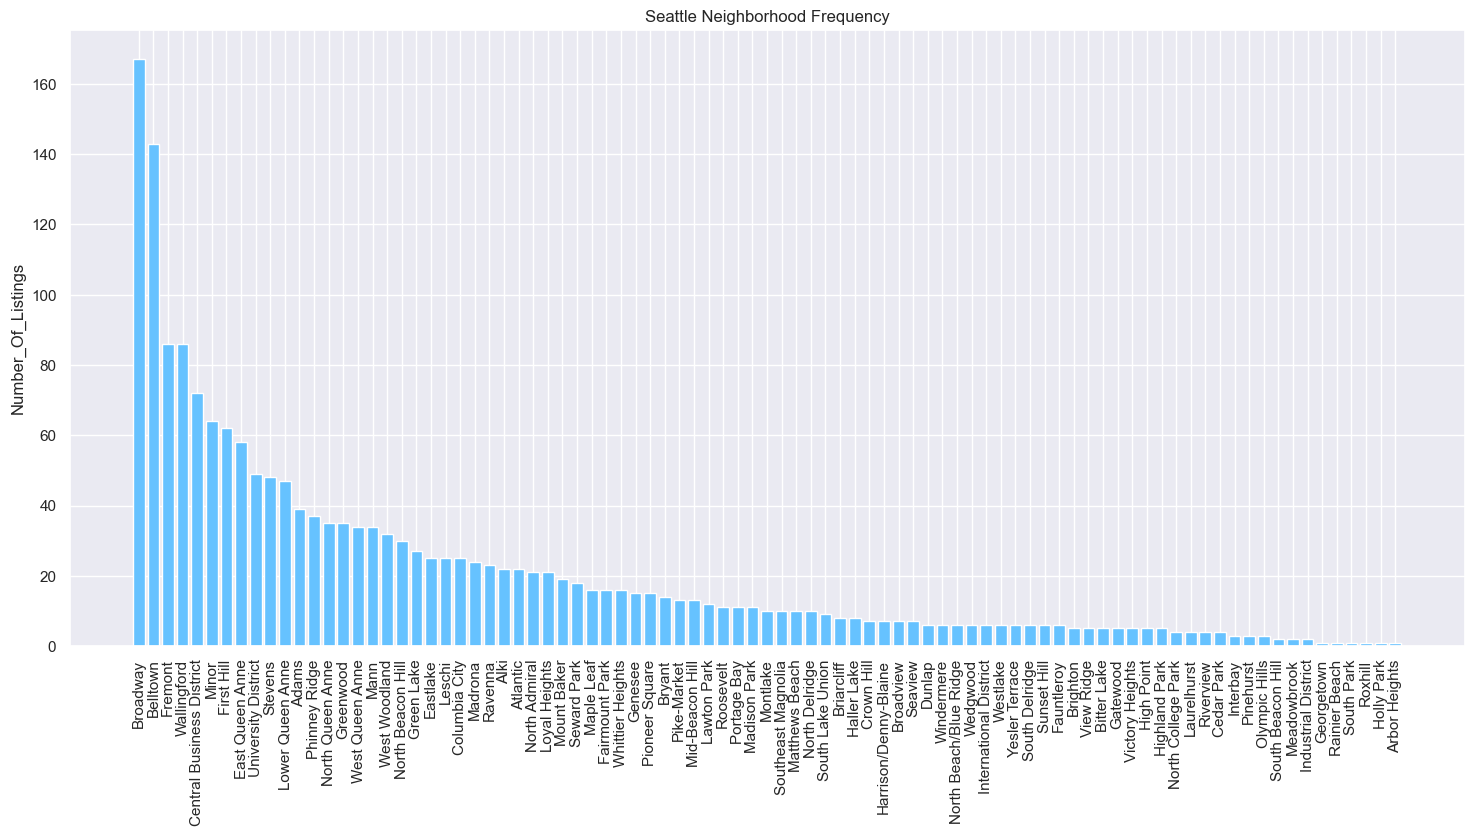

In [ ]:
# Extracting data from the DataFrame
objects = neighbourhood_DF.select('neighbourhood_cleansed').collect()
y_pos = neighbourhood_DF.select('Number_Of_Listings').collect()

# Unpacking the data from Row objects
objects = [row['neighbourhood_cleansed'] for row in objects]
y_pos = [row['Number_Of_Listings'] for row in y_pos]

# Creating the bar plot
plt.figure(figsize=(18, 8))
plt.bar(objects, y_pos, color='#66c2ff')
plt.title('Seattle Neighborhood Frequency')
plt.ylabel('Number_Of_Listings')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


## Conclusion: We can see that most of the listings appear in 'Broadway', 'Belltown', 'Fremont', 'East/North/West Queen Anne'. This gives us a good insight into the potential neighbourhoods where there are high number of listings. Our next step would be to analyze it with the price.

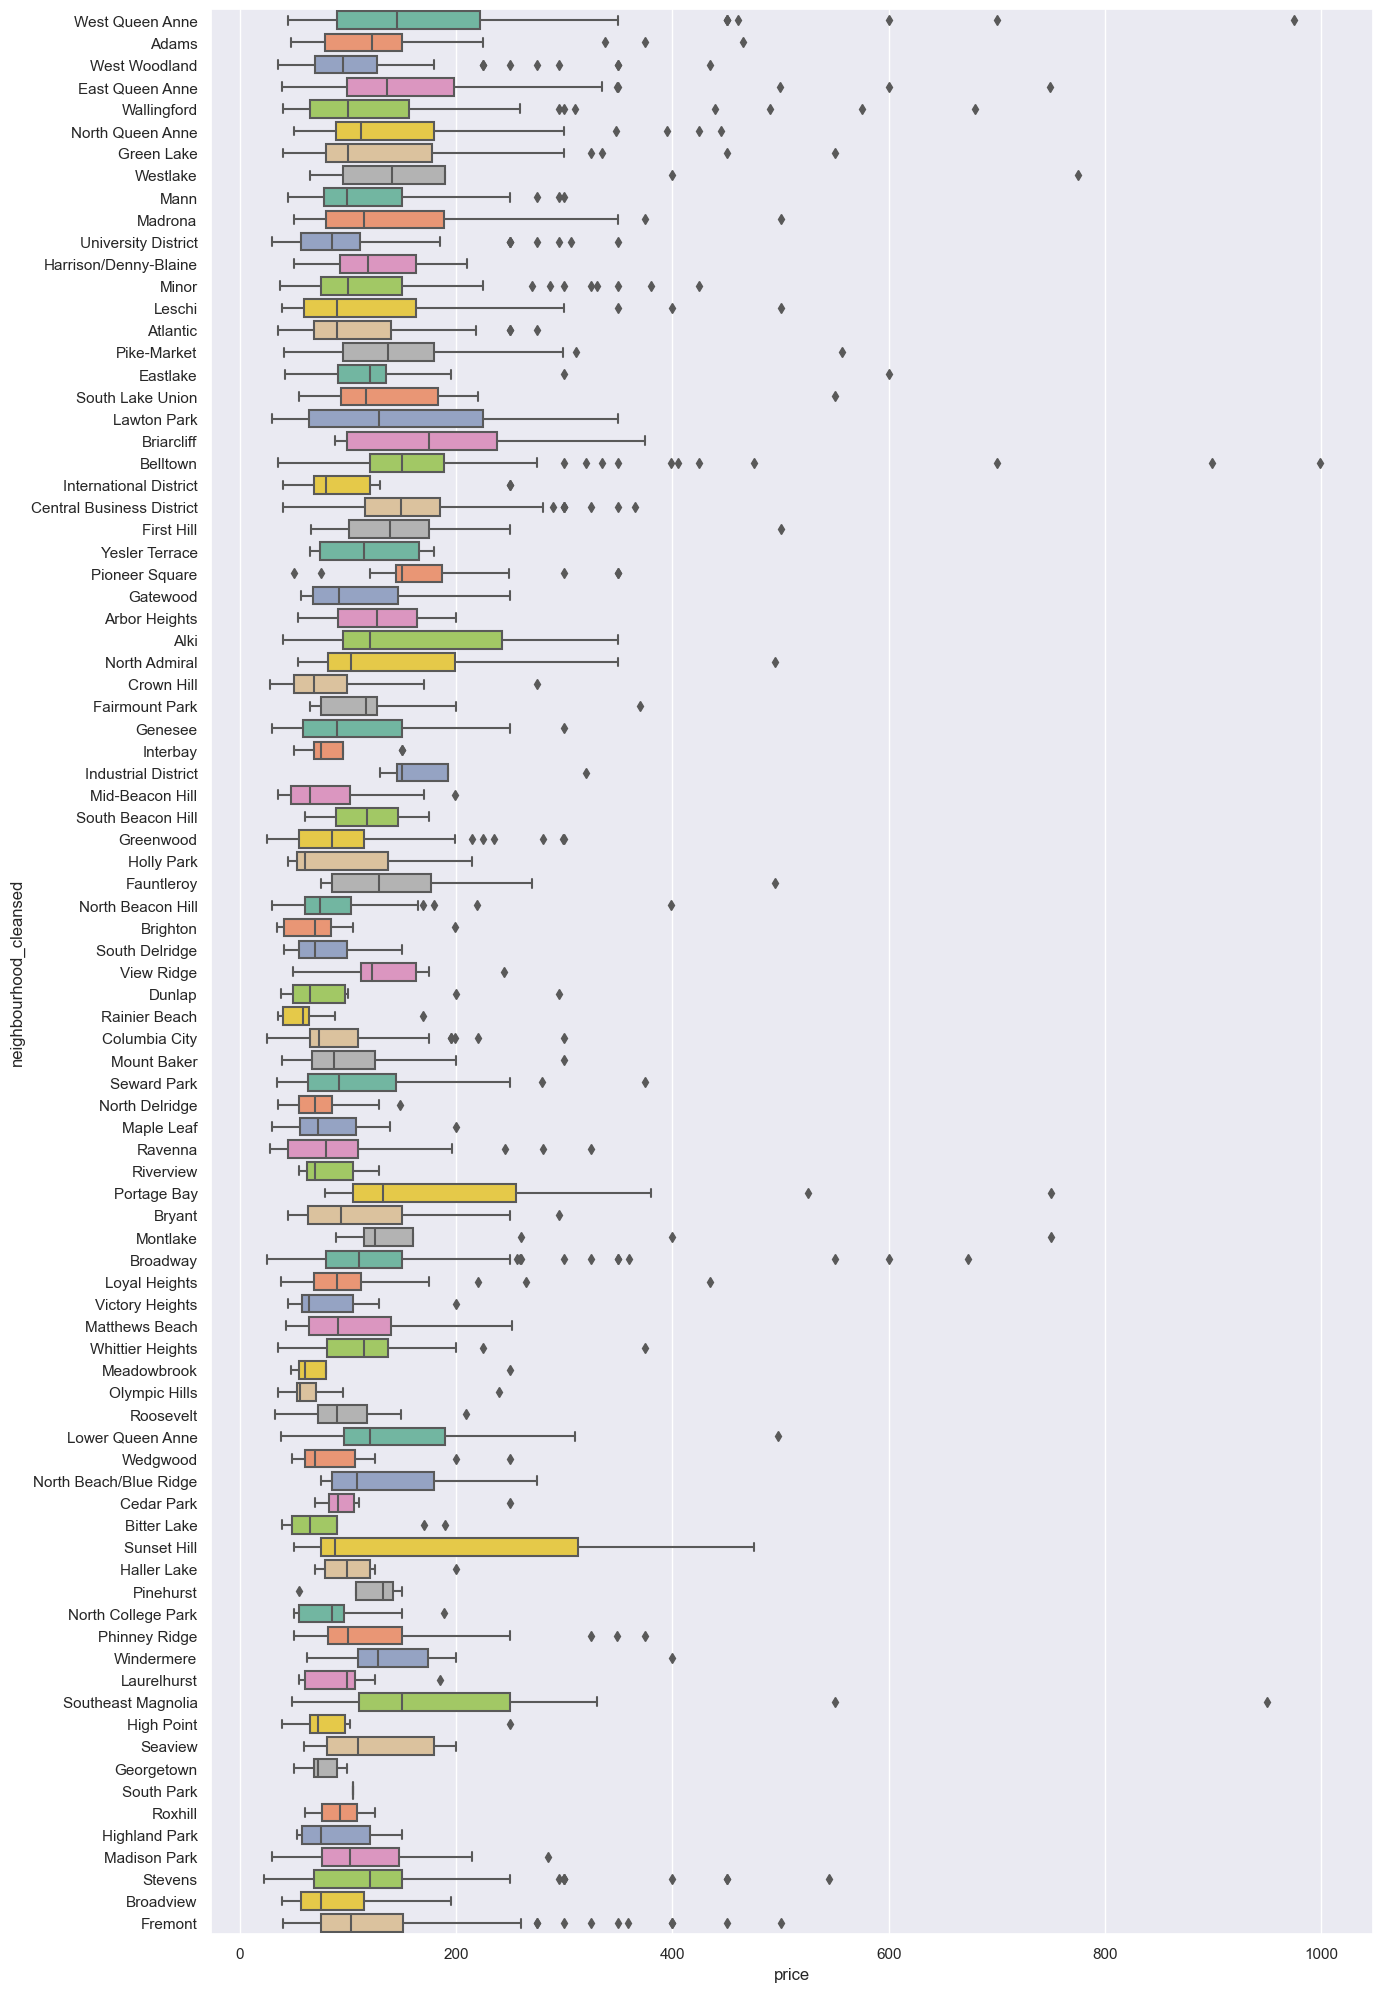

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = listings_df.select("price", "neighbourhood_cleansed").toPandas()

# Create a box plot using seaborn
plt.figure(figsize=(15, 25))
sns.boxplot(y="neighbourhood_cleansed", x="price", data=pandas_df, palette="Set2")
plt.show()


In [ ]:
# Extracting data from the PySpark DataFrame
neighbourhood_cleansed = neighbourhoodPrice_DF.select("neighbourhood_cleansed").rdd.flatMap(lambda x: x).collect()
median_price = neighbourhoodPrice_DF.select("Median_Price").rdd.flatMap(lambda x: x).collect()

# Plotting the bar plot using matplotlib
plt.figure(figsize=(15, 8))
plt.bar(neighbourhood_cleansed, median_price, color='#66c2ff')
plt.title('Seattle Neighborhood Median price')
plt.xlabel('Neighbourhood Cleansed')
plt.ylabel('Median Price')
plt.xticks(rotation=90)
plt.show()


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 132.0 failed 1 times, most recent failure: Lost task 0.0 in stage 132.0 (TID 82) (Lenovo-Ideapad-520 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\LP-7263\AppData\Roaming\Python\Python310\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 11) than that in driver 3.10, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\LP-7263\AppData\Roaming\Python\Python310\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 11) than that in driver 3.10, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
